# Introduction

Image-to-image translation is a fundamental task in computer vision that focuses on converting an image from one domain into a corresponding image in another. This project explores the use of **Cycle-Consistent Generative Adversarial Networks (CycleGANs)** for translating images between two visually distinct animals: cats and dogs. This tasks is more difficult than translating between two similar animals due to the differences in shape, texture, facial structure, fur patterns and other distinct features between cats and dogs. Unlike traditional methods requiring paired datasets, where an image of a cat is directly matched with an equivalent image of a dog, CycleGANs enable unpaired image-to-image translation, making them a great fit for this project.

The primary objective is to develop a model capable of transforming an image of a cat into an image of a dog, and vice versa, while preserving important attributes such as pose, orientation, and background context. Achieving this requires not only generating realistic textures and colors but also ensuring structural consistency between the input and output images.

For this project, I will utilize the **Kaggle Cats and Dogs dataset**, which provides a large collection of images containing various breeds, poses, lighting conditions, and backgrounds. This dataset introduces real-world variability, challenging the model to generalize across diverse scenarios.

**Project Goals:**

- Preprocessing: Efficiently process and augment the dataset to ensure the model receives high-quality and diverse input images.
- Model Architecture: Implement the CycleGAN framework, which consists of two generators (for cat-to-dog and dog-to-cat translation) and two discriminators (to distinguish real and generated images).
- Training Procedure: Train the CycleGAN using cycle-consistency loss, adversarial loss, and identity loss to ensure stable learning and realistic outputs.
- Evaluation: Assess the model’s performance both qualitatively, through visual inspection of translated images, and quantitatively using appropriate metrics.
- Challenges & Limitations: Address common issues such as mode collapse, training instability, and difficulties in capturing fine-grained details.


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import PIL.Image as Image
import seaborn as sns
import optuna

# Use GPU if available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.AUTOTUNE

2025-03-02 13:48:57.236253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740948537.247424   14557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740948537.250907   14557 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 13:48:57.267883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


# Data

For this project, I am using the [Kaggle Cat vs Dog Dataset](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset/data) on Kaggle.

## Overview

The dataset contains a collection of **~25,000 images** of cats and dogs, with **~12,500 images per class**. Each image varies in size, breed, pose, and lighting conditions, providing a diverse dataset ideal for training deep learning models. Images are named in the format `#.jpg"`, where `#` represents the image index relative to the `Cat` or `Dog` directory.

## Key Features

- **Balanced Classes:** Equal representation of cats and dogs means unbiased training.
- **Diverse Images:** Includes various cat and dog breeds with differences in fur color, texture, and facial structures.
- **Variability in Conditions:** Images come with varying backgrounds, poses, and lighting, enabling the model to generalize to real-world scenarios.
- **High Resolution:** Images are high-quality but will be resized for model compatibility during preprocessing.

## Dataset Structure

The dataset is broken into two directories in the following structure:

- Cat
  - 1.jpg
  - 2.jpg
  - ...
- Dog
  - 1.jpg
  - 2.jpg
  - ...


# Preprocessing

To prepare the dataset for CycleGAN training, the following preprocessing steps will be performed:

1. **Resizing:** Standardize all images to a consistent resolution (e.g., 256x256 pixels).
2. **Normalization:** Scale pixel values to the range [-1, 1] to improve model convergence.
3. **Data Augmentation:** Apply random flips, rotations, and color adjustments to increase dataset diversity and improve model robustness.


Cat-tfrec TFRecord Files: 1
Dog-tfrec TFRecord Files: 1


I0000 00:00:1740948540.229470   14557 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:08:00.0, compute capability: 8.9
2025-03-02 13:49:00.541128: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


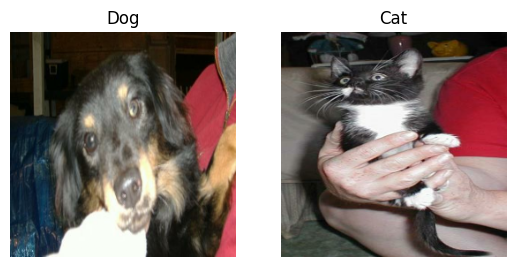

In [3]:
IMAGE_SIZE = (256, 256)


def get_tfrec_files(folder):
    """Get TFRecord files from a specified folder in the data directory."""
    files = tf.io.gfile.glob(os.path.join("data", folder, "*.tfrec"))
    print(f"{folder.capitalize()} TFRecord Files: {len(files)}")
    return files


def process_image(image_bytes):
    """Decode and preprocess an image from raw bytes."""
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image


def parse_record(record):
    """Parse a single TFRecord example."""
    features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(record, features)
    return process_image(parsed["image"])


def build_dataset(files, batch_size=8):
    """Create a batched dataset from a list of TFRecord files."""
    ds = tf.data.TFRecordDataset(files)
    ds = ds.map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


cat_files = get_tfrec_files("cat-tfrec")
dog_files = get_tfrec_files("dog-tfrec")

cat_ds = build_dataset(cat_files)
dog_ds = build_dataset(dog_files)

cat_sample = next(iter(cat_ds))[0]
dog_sample = next(iter(dog_ds))[0]

plt.subplot(121)
plt.title("Dog")
plt.axis("off")
plt.imshow(dog_sample * 0.5 + 0.5)

plt.subplot(122)
plt.title("Cat")
plt.axis("off")
plt.imshow(cat_sample * 0.5 + 0.5)
plt.show()

# Show sample images from each dataset


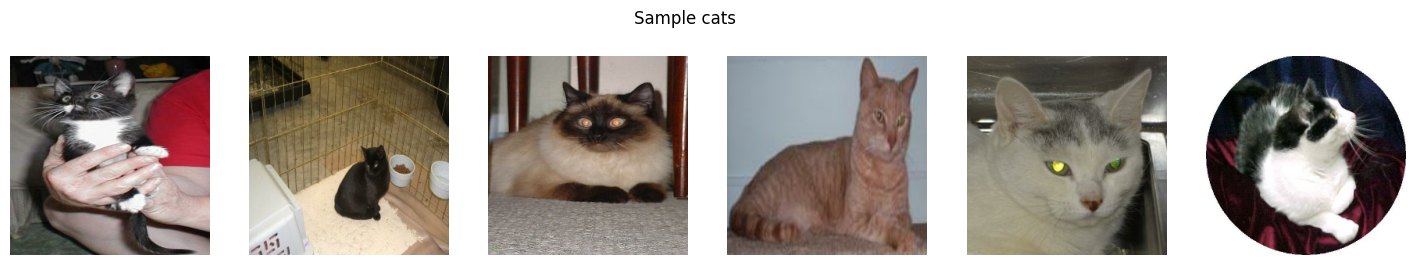

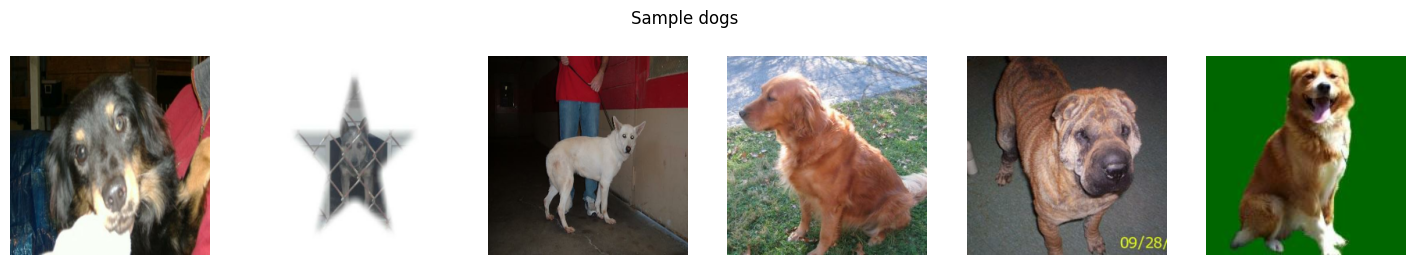

In [15]:
# Function to get a batch of images from a dataset
def get_sample_images(dataset, num_images=9):
    images = []
    for image in dataset.take(num_images):
        images.append(image[0].numpy())
    return np.array(images)


# Function to plot a grid of images
def plot_image_grid(images, title, grid_shape=(1, 6)):
    fig, axes = plt.subplots(
        grid_shape[0], grid_shape[1], figsize=(grid_shape[1] * 3, grid_shape[0] * 3)
    )
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < images.shape[0]:
            # Convert pixel range from [-1,1] to [0,1] for display
            ax.imshow(images[i] * 0.5 + 0.5)
        ax.axis("off")
    plt.show()


# Function to plot per-channel histograms
def plot_channel_histograms(images, title):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    channels = ["Red", "Green", "Blue"]
    colors = ["r", "g", "b"]

    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        channel_data = images[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.5, color=color, label=channels[i])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Function to compute and print mean and standard deviation
def compute_stats(images):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std


# Get sample images from each dataset
cat_samples = get_sample_images(cat_ds, num_images=6)
dog_samples = get_sample_images(dog_ds, num_images=6)

# Plot image grids
plot_image_grid(cat_samples, "Sample cats")
plot_image_grid(dog_samples, "Sample dogs")

# Exploratory Data Analysis (EDA)

## Overview

To better understand the dataset before training a CycleGAN model, I performed an exploratory data analysis (EDA) of the pixel intensity distributions for cat and dog images. The charts below represent the distribution of pixel intensities across the Red, Green, and Blue (RGB) channels for each category. This analysis helped in identifying potential color imbalances, background variations, and contrast differences between the two sets of images.

## Cat Images Pixel Distribution

- The distribution is relatively spread out across different intensity levels, with noticeable peaks around 0.6 and 1.0.
- The red channel shows strong peaks around mid-intensity values (~0.6) and high-intensity (1.0), indicating that cat images may have an obvious warm tone.
- The blue and green channels are also well-represented but appear to be more evenly distributed with more representation in the mid to low intensity values.
- There is a significant presence of all three colors at lower intensities, suggesting shadows or maybe darker fur patterns or backgrounds. Its also possible the cat images are more likely to be taken indoors due to the nature of cats in general.

## Dog Images Pixel Distribution

- The dog images have a stark difference RGB values compared to the cat images.
- The blue channel has a very strong presence at low intensity (near 0) and high intensity (1.0), suggesting a lot of dark or black regions in the dog images.
- The green channel has a sharp peak around 0.4, which might indicate a common background color like grass or trees. Compared to the cat images, its likely that the dog images more often are taken outside.
- There are strong peaks at 1.0, indicating bright or white regions, possibly common in dog fur.
- Compared to the cat image distribution, the dog images seem to have a more contrasted areas, with dominant low and high-intensity values.

## Key Takeaways for CycleGAN Training

1. **Background Differences:** If cat images contain more mid-intensity pixels while dog images have sharper contrasts, the model may struggle with background translation.
2. **Color Imbalance:** Dogs appear to have a more dominant blue/green intensity, while cats lean more towards red. This may introduce color shifts in generated images.


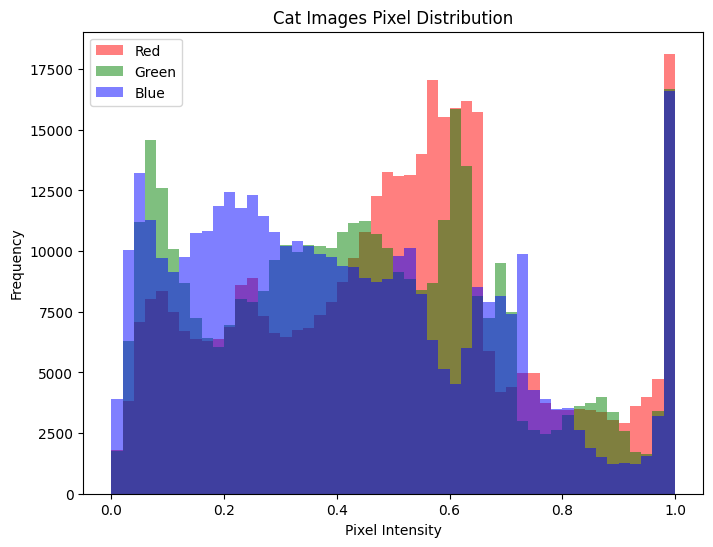

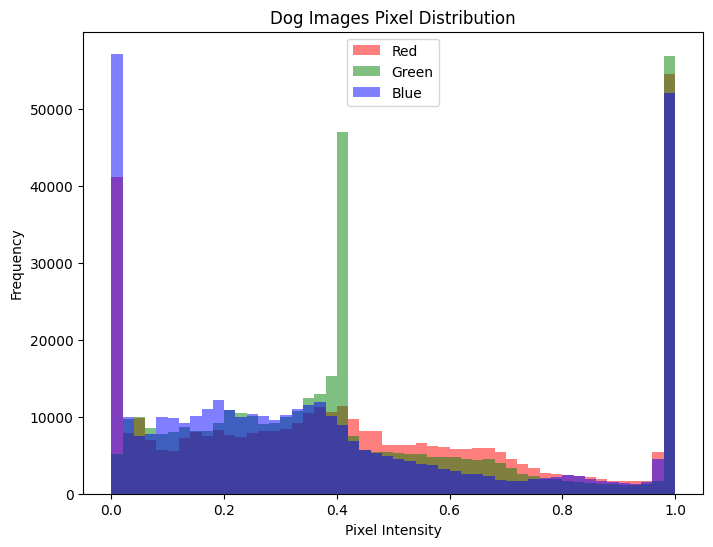

In [5]:
# Function to plot per-channel histograms
def plot_channel_histograms(images, title):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    channels = ["Red", "Green", "Blue"]
    colors = ["r", "g", "b"]

    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        channel_data = images[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.5, color=color, label=channels[i])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Function to compute and print mean and standard deviation
def compute_stats(images):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std


# Plot channel histograms
plot_channel_histograms(cat_samples, "Cat Images Pixel Distribution")
plot_channel_histograms(dog_samples, "Dog Images Pixel Distribution")

# Cat and Dog Image Analysis

As part of the exploratory data analysis (EDA), I examined the image dimensions, file sizes, and aspect ratios for the cat and dog image datasets. Understanding these properties would help in determining if resizing or preprocessing is needed to standardize the dataset before training.

## Image Dimensions

- Both cat and dog images show a diverse range of widths and heights, but there is a noticeable clustering around 400 and 500 pixels.
- The width distribution appears more variable than the height distribution, suggesting that images might have different aspect ratios.

## File Size Distribution

- The file sizes of both cat and dog images follow a roughly similar distribution, with most images ranging between 10,000 - 40,000 bytes.
- There is a peak in the mid-range (~20,000 bytes), indicating a common file compression level or resolution.
- A few outliers exist above 50,000 bytes, suggesting the presence of higher-resolution images that might need resizing for consistent training performance.

## Aspect Ratio Distribution

- The aspect ratio (width/height) distribution is quite varied but shows a strong peak around 1.3–1.4, indicating that many images have similar proportions.
- A notable portion of images have an aspect ratio close to 1.0, meaning they are nearly square.
- The distribution of aspect ratios between cats and dogs is similar, which is beneficial for CycleGAN training as it reduces the likelihood of shape distortion when translating between domains.

## Key Takeaways for CycleGAN Training

1. **Resizing Strategy:** Since image dimensions vary widely, resizing all images to a common resolution (in this project I selected 256x256) is necessary to maintain consistency in the dataset.
2. **Aspect Ratio Uniformity:** The presence of common aspect ratios suggests that cropping might not be required, but resizing to a standard size while preserving aspect ratios could be beneficial.


Cat JPG Files: 12405
Dog JPG Files: 12364


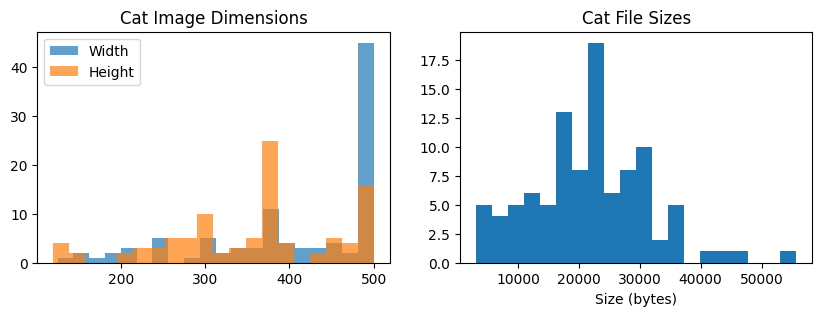

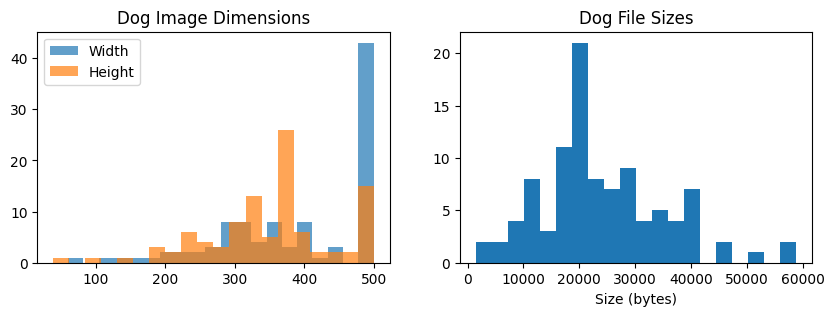

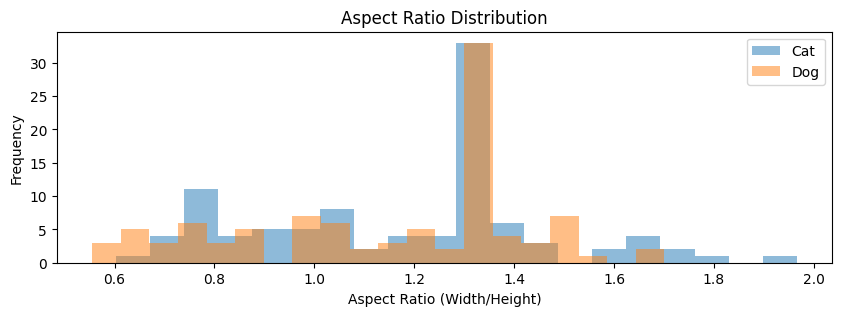

In [16]:
def get_jpg_files(folder):
    """Get JPG files from a specified folder in the data directory."""
    files = tf.io.gfile.glob(os.path.join("data", folder, "*.jpg"))
    print(f"{folder.capitalize()} JPG Files: {len(files)}")
    return files

def dataset_summary(files, folder):
    image_sizes = []
    file_sizes = []

    for file in files[:100]:  # Sample for speed
        with Image.open(file) as img:
            image_sizes.append(img.size)
            file_sizes.append(os.path.getsize(file))

    # Plot image dimension distributions and file size distribution
    widths, heights = zip(*image_sizes)
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].hist(widths, bins=20, alpha=0.7, label="Width")
    axes[0].hist(heights, bins=20, alpha=0.7, label="Height")
    axes[0].legend()
    axes[0].set_title(f"{folder} Image Dimensions")

    axes[1].hist(file_sizes, bins=20)
    axes[1].set_title(f"{folder} File Sizes")
    axes[1].set_xlabel("Size (bytes)")
    plt.show()

cat_jpg_files = get_jpg_files("Cat")
dog_jpg_files = get_jpg_files("Dog")

dataset_summary(cat_jpg_files, "Cat")
dataset_summary(dog_jpg_files, "Dog")


def aspect_ratio_analysis(files):
    ratios = []
    for file in files[:100]:
        with Image.open(file) as img:
            width, height = img.size
            ratios.append(width / height)
    return ratios


cat_ratios = aspect_ratio_analysis(cat_jpg_files)
dog_ratios = aspect_ratio_analysis(dog_jpg_files)

plt.figure(figsize=(10, 3))
plt.hist(cat_ratios, bins=20, alpha=0.5, label="Cat")
plt.hist(dog_ratios, bins=20, alpha=0.5, label="Dog")
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# CycleGAN Model Architecture

# CycleGAN Generator

This section of the CycleGAN model defines custom `Downsample` and `Upsample` layers, which are used to construct the generator. The generator follows a U-Net architecture, where images are progressively downsampled to extract high-level features and then upsampled to reconstruct the image in the target domain. This structure enables the model to learn transformations between different domains (e.g., converting images of cats to dogs) effectively.

## **Downsample Layer**

The `Downsample` class performs a strided convolution to reduce the spatial resolution of the input while increasing the number of filters. This helps in learning complex representations.

### **Key Components**

- **Convolution (`Conv2D`)**: A convolutional layer with a stride of 2 to downsample the input.
- **Instance Normalization (`GroupNormalization`)**: Normalizes feature maps, stabilizing training.
- **LeakyReLU Activation**: Allows small gradients for negative values, improving training for deep networks.

### **Call Method**

1. Applies a convolution operation.
2. If instance normalization is enabled, it normalizes the feature maps.
3. Passes the result through a LeakyReLU activation function.

## **Upsample Layer**

The `Upsample` class uses transposed convolution (also called deconvolution) to increase the spatial resolution, reconstructing finer image details.

### **Key Components**

- **Transposed Convolution (`Conv2DTranspose`)**: Expands the image by a factor of 2.
- **Group Normalization**: Normalizes feature maps like in `Downsample`.
- **Dropout (Optional)**: Prevents overfitting by randomly setting activations to zero.
- **ReLU Activation**: Used to introduce non-linearity.

### **Call Method**

1. Applies a transposed convolution.
2. Normalizes feature maps.
3. Applies dropout if specified.
4. Passes the result through a ReLU activation.

---

## **Generator Architecture**

The `Generator` class builds a U-Net-like network using `Downsample` and `Upsample` layers.

### **Structure**

- **Encoder (Downsampling)**:
  - 8 downsampling layers extract features and progressively reduce spatial dimensions.
  - The first layer does not apply instance normalization.
- **Decoder (Upsampling)**:
  - 7 upsampling layers reconstruct the image.
  - The first three layers apply dropout for regularization.
- **Skip Connections**:
  - Feature maps from downsampling layers are concatenated with corresponding upsampling layers (mirroring the U-Net architecture).
  - This helps retain spatial details lost in downsampling.
- **Final Output**:
  - A transposed convolution outputs the final image with 3 channels (RGB) and a `tanh` activation for pixel values between -1 and 1.

### **Call Method**

1. Passes input through downsampling layers while storing intermediate outputs for skip connections.
2. Upsampling layers reconstruct the image, using stored skip connections.
3. The final transposed convolution generates the output image.


In [7]:
class Downsample(layers.Layer):
    def __init__(self, filters, size, apply_instancenorm=True, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False,
        )
        self.norm = (
            tf.keras.layers.GroupNormalization(
                gamma_initializer=keras.initializers.RandomNormal(
                    mean=0.0, stddev=0.02
                ),
                groups=-1,
            )
            if apply_instancenorm
            else None
        )
        self.activation = layers.LeakyReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        if self.norm:
            x = self.norm(x)
        return self.activation(x)


class Upsample(layers.Layer):
    def __init__(self, filters, size, apply_dropout=False, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False,
        )
        self.norm = tf.keras.layers.GroupNormalization(
            gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
            groups=-1,
        )
        self.dropout = layers.Dropout(0.5) if apply_dropout else None
        self.activation = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.conv_transpose(inputs)
        x = self.norm(x)
        if self.dropout:
            x = self.dropout(x, training=training)
        return self.activation(x)


class Generator(keras.Model):
    def __init__(self, output_channels=3, **kwargs):
        super().__init__(**kwargs)
        self.down_stack = [
            Downsample(64, 4, apply_instancenorm=False),
            Downsample(128, 4),
            Downsample(256, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
        ]

        self.up_stack = [
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4),
            Upsample(256, 4),
            Upsample(128, 4),
            Upsample(64, 4),
        ]

        self.last_conv = layers.Conv2DTranspose(
            output_channels,
            4,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation="tanh",
        )
        self.concat = layers.Concatenate()

    def call(self, inputs, training=False):
        x = inputs
        skips = []
        for down in self.down_stack:
            x = down(x, training=training)
            skips.append(x)
        # Remove the bottleneck output and reverse the skip connections
        skips = list(reversed(skips[:-1]))
        for up, skip in zip(self.up_stack, skips):
            x = up(x, training=training)
            x = self.concat([x, skip])
        return self.last_conv(x)

# CycleGAN Discriminator

The `Discriminator` class defines a PatchGAN discriminator, which determines whether an input image is real or generated. Instead of classifying an entire image as real or fake, PatchGAN classifies small overlapping patches, helping the model focus on local features and textures.

In the CycleGAN setup, two discriminators are used:

- **`cat_discriminator`**: Differentiates real cat images from fake ones generated by the `dog_generator`.
- **`dog_discriminator`**: Differentiates real dog images from fake ones generated by the `cat_generator`.

## **Discriminator Architecture**

The discriminator consists of several **downsampling layers** followed by a final classification layer.

### **1. Downsampling Layers**

The first three layers progressively reduce the spatial dimensions while increasing the number of filters:

- **`down1` (64 filters, 4x4 kernel, no instance normalization)**: Extracts low-level features from the image.
- **`down2` (128 filters, 4x4 kernel)**: Captures more complex structures.
- **`down3` (256 filters, 4x4 kernel)**: Deepens feature representation.

Each downsampling layer follows the same pattern:

- **Strided Convolution (`Conv2D`)** to downsample the image.
- **Group Normalization** (except in the first layer).
- **LeakyReLU Activation** to allow small negative gradients.

### **2. Final Classification Layers**

After downsampling, the model applies:

- **`ZeroPadding2D`**: Adds padding before the last convolution layers.
- **`conv` (512 filters, 4x4 kernel, stride 1)**: Expands the feature representation.
- **`GroupNormalization`**: Normalizes activations for stable training.
- **`LeakyReLU`**: Introduces non-linearity.
- **Another `ZeroPadding2D`**: Ensures correct feature map dimensions before the last convolution.
- **Final `Conv2D` (1 filter, 4x4 kernel, stride 1)**: Produces a **patch-based real/fake classification map**.

## **Call Method**

1. The input image is passed through the three downsampling layers.
2. Padding is added before applying the final convolution layers.
3. The output is a **feature map** where each patch represents the probability of real vs. fake classification.

## **Why PatchGAN?**

- Instead of classifying an entire image as real or fake, PatchGAN checks **local patches**, improving texture and detail preservation.
- Helps **focus on smaller regions**, making the model more robust to mode collapse and global structure inconsistencies.
- Reduces the number of parameters compared to full-image discriminators.

## **How the Discriminator Works in CycleGAN**

1. The `dog_generator` generates fake cat images from dog images.
2. `cat_discriminator` evaluates these fake cat images, distinguishing them from real cat images.
3. Similarly, the `cat_generator` produces fake dog images, which `dog_discriminator` assesses.
4. Both discriminators are trained to improve their classification ability, forcing the generators to produce more realistic images.


In [8]:
class Discriminator(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        initializer = tf.random_normal_initializer(0.0, 0.02)
        gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        self.down1 = Downsample(64, 4, apply_instancenorm=False)
        self.down2 = Downsample(128, 4)
        self.down3 = Downsample(256, 4)
        self.zero_pad1 = layers.ZeroPadding2D()
        self.conv = layers.Conv2D(
            512, 4, strides=1, kernel_initializer=initializer, use_bias=False
        )
        self.norm1 = layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1)
        self.leaky_relu = layers.LeakyReLU()
        self.zero_pad2 = layers.ZeroPadding2D()
        self.last_conv = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)

    def call(self, inputs, training=False):
        x = self.down1(inputs, training=training)
        x = self.down2(x, training=training)
        x = self.down3(x, training=training)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.norm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.last_conv(x)


with strategy.scope():
    cat_generator = Generator()  # transforms dogs to cats
    dog_generator = Generator()  # transforms cats to dogs
    cat_discriminator = Discriminator()  # differentiates dogs vs. generated cats
    dog_discriminator = Discriminator()  # differentiates cats vs. generated dogs

# CycleGAN Training Process

The `CycleGan` class defines the full CycleGAN model, integrating:

- Two generators (`cat_gen` and `dog_gen`) for translating images between domains.
- Two discriminators (`cat_disc` and `dog_disc`) for evaluating real vs. generated images.
- Custom loss functions for adversarial, cycle-consistency, and identity losses.

This structure enables unsupervised image-to-image translation, ensuring that generated images are realistic and retain essential content from the original.

---

## **CycleGAN Model Components**

### **1. Initialization (`__init__` method)**

- Stores references to the **generators** and **discriminators**.
- Defines the **cycle consistency weight** (`lambda_cycle`), which controls the importance of cycle-consistency loss.

### **2. Compilation (`compile` method)**

- Stores the optimizers for both generators and discriminators.
- Stores the loss functions:
  - **`gen_loss_fn`**: Adversarial loss for generators.
  - **`disc_loss_fn`**: Adversarial loss for discriminators.
  - **`cycle_loss_fn`**: Ensures generated images can be mapped back to their original domain.
  - **`identity_loss_fn`**: Encourages generators to preserve image details when given a target-domain image as input.

## **Training Workflow**

### **3. Computing Losses (`compute_losses` method)**

This function performs forward passes through both generators and discriminators, calculating all necessary losses.

#### **Image Generation**

- The generators translate between domains:
  - `dog_gen` transforms **cats → fake dogs**.
  - `cat_gen` transforms **dogs → fake cats**.
- Cycle-consistency ensures:
  - Transforming `real_dog → fake_cat → cycled_dog` should approximate `real_dog`.
  - Transforming `real_cat → fake_dog → cycled_cat` should approximate `real_cat`.
- Identity loss encourages `cat_gen(real_cat) ≈ real_cat` and `dog_gen(real_dog) ≈ real_dog`.

#### **Discriminator Evaluations**

- Each discriminator determines whether real and generated images are authentic.

#### **Loss Computation**

- **Generator Loss**: Encourages fake images to be classified as real.
- **Cycle Loss**: Ensures cycle consistency between transformations.
- **Identity Loss**: Ensures minimal distortion when translating an image into its own domain.
- **Discriminator Loss**: Helps distinguish real images from generated ones.

### **4. Training Step (`train_step` method)**

This method defines how the model updates during each training step.

#### **Forward Pass**

- Calls `compute_losses` to obtain all loss values.

#### **Gradient Calculation**

- Uses **`tf.GradientTape`** to compute gradients for:
  - Generators (`cat_gen`, `dog_gen`).
  - Discriminators (`cat_disc`, `dog_disc`).

#### **Gradient Application**

- Uses optimizers to update model parameters:
  - `apply_gradients` applies calculated gradients to improve performance.

---

## **CycleGAN Loss Functions**

The `CycleGanLosses` class defines the loss functions required for adversarial training.

### **1. Discriminator Loss**

- Uses **Binary Cross-Entropy (BCE)** to classify real vs. fake images.
- Computes loss separately for **real** and **generated** images.
- Averaged to ensure balanced updates.

### **2. Generator Loss**

- Encourages the generator to fool the discriminator into classifying fake images as real.

### **3. Cycle Loss**

- Uses **Mean Absolute Error (L1 loss)** to ensure that transforming an image into another domain and back preserves key features.
- Weighted by `lambda_cycle` to control its contribution.

### **4. Identity Loss**

- Encourages the generator to maintain identity when processing images from its own domain.
- Helps prevent unnecessary transformations.


In [9]:
class CycleGan(keras.Model):
    def __init__(
        self, cat_gen, dog_gen, cat_disc, dog_disc, lambda_cycle=10, **kwargs
    ):
        super().__init__(**kwargs)
        self.m_gen = cat_gen
        self.p_gen = dog_gen
        self.m_disc = cat_disc
        self.p_disc = dog_disc
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        **kwargs
    ):
        super().compile(**kwargs)
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def compute_losses(self, real_cat, real_dog):
        # Generate fake images and their cycles
        fake_cat = self.m_gen(real_dog, training=True)
        cycled_dog = self.p_gen(fake_cat, training=True)
        fake_dog = self.p_gen(real_cat, training=True)
        cycled_cat = self.m_gen(fake_dog, training=True)

        # Identity mappings
        same_cat = self.m_gen(real_cat, training=True)
        same_dog = self.p_gen(real_dog, training=True)

        # Discriminator evaluations
        disc_real_cat = self.m_disc(real_cat, training=True)
        disc_fake_cat = self.m_disc(fake_cat, training=True)
        disc_real_dog = self.p_disc(real_dog, training=True)
        disc_fake_dog = self.p_disc(fake_dog, training=True)

        # Generator losses
        cat_gen_loss = self.gen_loss_fn(disc_fake_cat)
        dog_gen_loss = self.gen_loss_fn(disc_fake_dog)

        cycle_loss = self.cycle_loss_fn(
            real_cat, cycled_cat, self.lambda_cycle
        ) + self.cycle_loss_fn(real_dog, cycled_dog, self.lambda_cycle)

        id_loss_cat = self.identity_loss_fn(real_cat, same_cat, self.lambda_cycle)
        id_loss_dog = self.identity_loss_fn(real_dog, same_dog, self.lambda_cycle)

        total_cat_gen_loss = cat_gen_loss + cycle_loss + id_loss_cat
        total_dog_gen_loss = dog_gen_loss + cycle_loss + id_loss_dog

        # Discriminator losses
        cat_disc_loss = self.disc_loss_fn(disc_real_cat, disc_fake_cat)
        dog_disc_loss = self.disc_loss_fn(disc_real_dog, disc_fake_dog)

        return {
            "total_cat_gen_loss": total_cat_gen_loss,
            "total_dog_gen_loss": total_dog_gen_loss,
            "cat_disc_loss": cat_disc_loss,
            "dog_disc_loss": dog_disc_loss,
        }

    @tf.function
    def train_step(self, batch_data):
        real_cat, real_dog = batch_data

        with tf.GradientTape(persistent=True) as tape:
            losses = self.compute_losses(real_cat, real_dog)

        # Compute gradients for generators
        m_gen_grads = tape.gradient(
            losses["total_cat_gen_loss"], self.m_gen.trainable_variables
        )
        p_gen_grads = tape.gradient(
            losses["total_dog_gen_loss"], self.p_gen.trainable_variables
        )
        # Compute gradients for discriminators
        m_disc_grads = tape.gradient(
            losses["cat_disc_loss"], self.m_disc.trainable_variables
        )
        p_disc_grads = tape.gradient(
            losses["dog_disc_loss"], self.p_disc.trainable_variables
        )

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(
            zip(m_gen_grads, self.m_gen.trainable_variables)
        )
        self.p_gen_optimizer.apply_gradients(
            zip(p_gen_grads, self.p_gen.trainable_variables)
        )
        self.m_disc_optimizer.apply_gradients(
            zip(m_disc_grads, self.m_disc.trainable_variables)
        )
        self.p_disc_optimizer.apply_gradients(
            zip(p_disc_grads, self.p_disc.trainable_variables)
        )

        return {
            "cat_gen_loss": losses["total_cat_gen_loss"],
            "dog_gen_loss": losses["total_dog_gen_loss"],
            "cat_disc_loss": losses["cat_disc_loss"],
            "dog_disc_loss": losses["dog_disc_loss"],
        }

In [10]:
class CycleGanLosses:
    @staticmethod
    def discriminator_loss(real, generated):
        bce = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        real_loss = bce(tf.ones_like(real), real)
        generated_loss = bce(tf.zeros_like(generated), generated)
        return 0.5 * (real_loss + generated_loss)

    @staticmethod
    def generator_loss(generated):
        bce = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        return bce(tf.ones_like(generated), generated)

    @staticmethod
    def cycle_loss(real_image, cycled_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return lambda_cycle * loss

    @staticmethod
    def identity_loss(real_image, same_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_cycle * 0.5 * loss

# Initial Training and Image Generation

## **1. Model Initialization and Compilation**

Before training begins, the CycleGAN model is instantiated and configured with key components:

- **Optimizers**: Adam optimizers are used for both generators and discriminators with:
  - Learning rate of **2e-4** for stable convergence.
  - **β1 = 0.5** to reduce momentum bias in the Adam optimizer.
- **Loss Functions**: The model is compiled with:
  - **Generator Loss**: Encourages realistic image generation.
  - **Discriminator Loss**: Helps differentiate real vs. fake images.
  - **Cycle Consistency Loss**: Ensures transformations are reversible.
  - **Identity Loss**: Helps preserve content when generating same-domain images.

By setting up the optimizers and losses, the CycleGAN is ready for training.

## **2. Initial Training Run**

The `cycle_gan_model.fit()` function is commented out but is set to train for **one epoch** using a dataset of paired cat and dog images (`tf.data.Dataset.zip((cat_ds, dog_ds))`). Running this step would:

- Train the generators to learn domain translations.
- Train the discriminators to refine their ability to classify real vs. fake images.
- Adjust model weights using the loss functions and optimizers.

## **3. Testing Generated Images**

The `generate_images()` function visually validates the model’s performance by:

- Selecting **six random dog images** from `dog_ds`.
- Passing each image through the `cat_generator` (dog → fake cat).
- Displaying **input dog images** in the first row.
- Displaying **generated cat images** in the second row.

### **Image Processing Steps**

1. **Denormalization**: Since images are scaled between `[-1, 1]` during training, they are rescaled back to `[0, 255]` for visualization.
2. **Image Transformation**: The `cat_generator` is run in **inference mode** (`training=False`) to generate cat-like images from dog inputs.
3. **Visualization**: A 2-row grid (`2x6`) is plotted using `matplotlib`, with:
   - Row 1: **Original dog images**
   - Row 2: **Generated cat images**
   - Y-axis labels indicating the transformation.

### **Purpose of Image Testing**

This step **validates whether the generator has learned meaningful transformations** even before full training. By inspecting the outputs, adjustments can be made to:

- Loss weighting (e.g., increasing cycle consistency penalty).
- Generator and discriminator architectures.
- Training duration (more epochs may be required for better results).


In [ ]:
with strategy.scope():
    # Configure optimizers with shared settings
    optimizer_config = {"learning_rate": 2e-4, "beta_1": 0.5}
    cat_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    dog_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    cat_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    dog_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)

    # Instantiate and compile the CycleGAN model using the new loss functions
    cycle_gan_model = CycleGan(
        cat_generator, dog_generator, cat_discriminator, dog_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer=cat_generator_optimizer,
        p_gen_optimizer=dog_generator_optimizer,
        m_disc_optimizer=cat_discriminator_optimizer,
        p_disc_optimizer=dog_discriminator_optimizer,
        gen_loss_fn=CycleGanLosses.generator_loss,
        disc_loss_fn=CycleGanLosses.discriminator_loss,
        cycle_loss_fn=CycleGanLosses.cycle_loss,
        identity_loss_fn=CycleGanLosses.identity_loss,
    )

cycle_gan_model.fit(tf.data.Dataset.zip((cat_ds, dog_ds)), epochs=1)

In [ ]:
def generate_images():
    fig, ax = plt.subplots(2, 6, figsize=(18, 6))
    for i, img in enumerate(dog_ds.shuffle(10).take(6)):
        original = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        transformed = cat_generator(img, training=False)[0].numpy()
        transformed = (transformed * 127.5 + 127.5).astype(np.uint8)

        ax[0, i].imshow(original)
        ax[0, i].axis("off")
        ax[1, i].imshow(transformed)
        ax[1, i].axis("off")

    ax[0, 0].set_ylabel("Input Dog Photos", fontsize=14)
    ax[1, 0].set_ylabel("Cat Transformations", fontsize=14)
    plt.tight_layout()
    plt.show()

generate_images()

# Hyperparameter Tuning and Retraining

Hyperparameter tuning is a crucial step in optimizing the performance of CycleGAN. This process systematically searches for the best learning rate, optimizer settings, and cycle consistency weighting to improve training stability and output quality.

The tuning is performed using **Optuna**, an efficient hyperparameter optimization library, which searches for optimal values based on the generator loss.

## **1. Hyperparameter Optimization with Optuna**

The function `objective(trial)` defines an Optuna trial where different hyperparameters are tested:

### **Hyperparameters Being Tuned**

- **Learning Rate (`learning_rate`)**: Sampled from `[1e-5, 1e-3]` (log-scaled) to control the speed of weight updates.
- **Adam Beta1 (`beta_1`)**: Sampled from `[0.0, 0.9]`, affecting momentum in the Adam optimizer.
- **Cycle Consistency Weight (`lambda_cycle`)**: Sampled from `[5, 15]`, determining the strength of the cycle-consistency loss.

### **Trial Process**

1. **Random Hyperparameter Sampling**: Optuna selects a combination of values within predefined ranges.
2. **Model Compilation**:
   - The **Adam optimizer** is configured with the sampled learning rate and beta1 value.
   - The **CycleGAN model** is instantiated with the sampled `lambda_cycle`.
   - The model is compiled with appropriate loss functions.
3. **Training for 1 Epoch**:
   - The model is trained on a dataset of cat and dog images.
   - The generator loss (`cat_gen_loss`) is extracted and averaged.
4. **Loss Validation**:
   - If the loss is non-finite (e.g., NaN or Inf), the trial is discarded.
   - The final loss value is returned to Optuna for optimization.

### **Optimization Execution**

- `study.optimize(objective, n_trials=5)` runs **five trials**, testing different hyperparameter values.
- The best hyperparameters are printed after optimization.

#### **Example Results**

- **Single trial result**:  
  `{ 'learning_rate': 2.73e-05, 'beta_1': 0.1687, 'lambda_cycle': 12.72 }`
- **After five trials**:  
  `{ 'learning_rate': 0.000279, 'beta_1': 0.5015, 'lambda_cycle': 8.945 }`

## **2. Retraining CycleGAN with Optimal Hyperparameters**

Once the best hyperparameters are determined, the model is **retrained** for improved performance.

### **Steps for Retraining**

1. **Best hyperparameters are extracted** from Optuna.
2. **Optimizers are configured** using the best `learning_rate` and `beta_1` values.
3. **CycleGAN is recompiled** with the optimal `lambda_cycle`.
4. **Model is trained for 5 epochs** using `cycle_gan_model.fit()`.

## **3. Regenerate Images to View Results**

After retraining another set of images is generator using the newly optimized and trained model with hopefully, improved performance.


In [13]:
def objective(trial):
    try:
        # Define hyperparameters
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        beta_1 = trial.suggest_float("beta_1", 0.0, 0.9)
        lambda_cycle = trial.suggest_float("lambda_cycle", 5, 15)
        epochs = 1

        # Configure optimizers
        optimizer_config = {"learning_rate": learning_rate, "beta_1": beta_1}
        cat_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
        dog_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
        cat_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
        dog_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)

        # Instantiate and compile model
        with strategy.scope():
            cycle_gan_model = CycleGan(
                cat_generator,
                dog_generator,
                cat_discriminator,
                dog_discriminator,
                lambda_cycle=lambda_cycle,
            )

            cycle_gan_model.compile(
                m_gen_optimizer=cat_generator_optimizer,
                p_gen_optimizer=dog_generator_optimizer,
                m_disc_optimizer=cat_discriminator_optimizer,
                p_disc_optimizer=dog_discriminator_optimizer,
                gen_loss_fn=CycleGanLosses.generator_loss,
                disc_loss_fn=CycleGanLosses.discriminator_loss,
                cycle_loss_fn=CycleGanLosses.cycle_loss,
                identity_loss_fn=CycleGanLosses.identity_loss,
            )

        # Train the model
        history = cycle_gan_model.fit(
            tf.data.Dataset.zip((cat_ds, dog_ds)),
            epochs=epochs,
        )

        # Extract loss - handle potential non-scalar values
        cat_gen_losses = history.history["cat_gen_loss"]
        if isinstance(cat_gen_losses, (list, np.ndarray)):
            loss = float(np.mean(cat_gen_losses))
        else:
            loss = float(cat_gen_losses)

        # Validate loss
        if not np.isfinite(loss):
            raise ValueError("Loss value is not finite")

        print(f"Trial completed with loss: {loss}")
        return loss

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        raise optuna.exceptions.TrialPruned()


# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=5)
# print("Best hyperparameters: ", study.best_params)

# 1 trial
# Best hyperparameters:  {'learning_rate': 2.7262211174438973e-05, 'beta_1': 0.16874939882380008, 'lambda_cycle': 12.720006238095113}
# 5 trials
# Best hyperparameters:  {'learning_rate': 0.0002793447590688152, 'beta_1': 0.5014848894861316, 'lambda_cycle': 8.945432168241094}

```
[I 2025-03-02 10:04:20,729] A new study created in memory with name: no-name-c829ecc6-52b3-43a6-ab98-9b089686062b
2025-03-02 10:05:04.420708: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads

1545/1545 ━━━━━━━━━━━━━━━━━━━━ 356s 202ms/step - cat_disc_loss: 0.6616 - cat_gen_loss: 2.8553 - dog_disc_loss: 0.6174 - dog_gen_loss: 3.0861
2025-03-02 10:10:16.906949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9357376193635459198
[I 2025-03-02 10:10:16,924] Trial 0 finished with value: 2.3575639724731445 and parameters: {'learning_rate': 0.0002240062074139713, 'beta_1': 0.8989979325852782, 'lambda_cycle': 14.085904806621466}. Best is trial 0 with value: 2.3575639724731445.
Trial completed with loss: 2.3575639724731445
2025-03-02 10:11:02.973329: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads

1545/1545 ━━━━━━━━━━━━━━━━━━━━ 365s 206ms/step - cat_disc_loss: 0.6588 - cat_gen_loss: 2.3574 - dog_disc_loss: 0.6673 - dog_gen_loss: 2.3829
2025-03-02 10:16:21.463289: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
[I 2025-03-02 10:16:21,483] Trial 1 finished with value: 1.9751031398773193 and parameters: {'learning_rate': 0.0002335643967783478, 'beta_1': 0.2987138492031855, 'lambda_cycle': 14.489911318157255}. Best is trial 1 with value: 1.9751031398773193.
Trial completed with loss: 1.9751031398773193
2025-03-02 10:17:09.262371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads

1545/1545 ━━━━━━━━━━━━━━━━━━━━ 367s 206ms/step - cat_disc_loss: 0.6633 - cat_gen_loss: 1.6073 - dog_disc_loss: 0.6606 - dog_gen_loss: 1.6250
[I 2025-03-02 10:22:28,471] Trial 2 finished with value: 1.3582993745803833 and parameters: {'learning_rate': 0.0002793447590688152, 'beta_1': 0.5014848894861316, 'lambda_cycle': 8.945432168241094}. Best is trial 2 with value: 1.3582993745803833.
Trial completed with loss: 1.3582993745803833
2025-03-02 10:23:12.827564: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads

1545/1545 ━━━━━━━━━━━━━━━━━━━━ 363s 206ms/step - cat_disc_loss: 0.6526 - cat_gen_loss: 2.1411 - dog_disc_loss: 0.6453 - dog_gen_loss: 2.1651
[I 2025-03-02 10:28:31,671] Trial 3 finished with value: 1.8878726959228516 and parameters: {'learning_rate': 0.0003757250181790442, 'beta_1': 0.16440195567563662, 'lambda_cycle': 14.788988627043363}. Best is trial 2 with value: 1.3582993745803833.
Trial completed with loss: 1.8878726959228516
2025-03-02 10:29:17.321271: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads

1545/1545 ━━━━━━━━━━━━━━━━━━━━ 364s 206ms/step - cat_disc_loss: 0.6464 - cat_gen_loss: 1.7562 - dog_disc_loss: 0.6376 - dog_gen_loss: 1.7745
[I 2025-03-02 10:34:35,711] Trial 4 finished with value: 1.5050657987594604 and parameters: {'learning_rate': 0.00014240987680082368, 'beta_1': 0.6034314682981701, 'lambda_cycle': 12.46315615504459}. Best is trial 2 with value: 1.3582993745803833.
Trial completed with loss: 1.5050657987594604
Best hyperparameters:  {'learning_rate': 0.0002793447590688152, 'beta_1': 0.5014848894861316, 'lambda_cycle': 8.945432168241094}
```

Epoch 1/5


I0000 00:00:1740948567.749115   14733 service.cc:148] XLA service 0x7fdbe80024f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740948567.749194   14733 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-02 13:49:28.999021: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740948571.551528   14733 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-03-02 13:49:58.681266: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1740948598.931881   14733 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 716s 427ms/step - cat_disc_loss: 0.6747 - cat_gen_loss: 2.4635 - dog_disc_loss: 0.6778 - dog_gen_loss: 2.4703
Epoch 2/5


2025-03-02 14:00:59.129498: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 721s 466ms/step - cat_disc_loss: 0.6771 - cat_gen_loss: 1.7792 - dog_disc_loss: 0.6690 - dog_gen_loss: 1.8154
Epoch 3/5
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 744s 482ms/step - cat_disc_loss: 0.6714 - cat_gen_loss: 1.6161 - dog_disc_loss: 0.6651 - dog_gen_loss: 1.6458
Epoch 4/5


2025-03-02 14:25:24.096950: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 328s 213ms/step - cat_disc_loss: 0.6651 - cat_gen_loss: 1.5485 - dog_disc_loss: 0.6590 - dog_gen_loss: 1.5742
Epoch 5/5
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 324s 210ms/step - cat_disc_loss: 0.6623 - cat_gen_loss: 1.5142 - dog_disc_loss: 0.6560 - dog_gen_loss: 1.5369


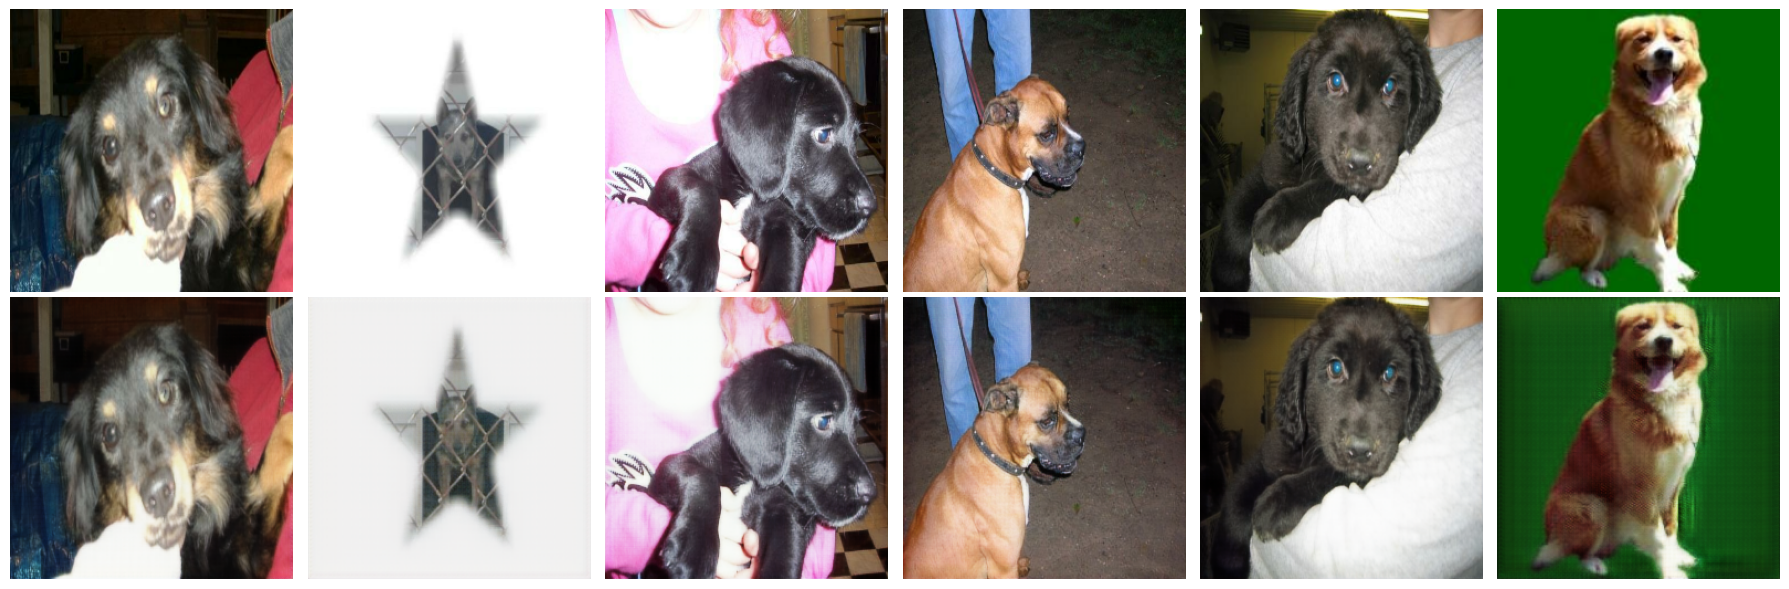

In [14]:
with strategy.scope():
    # Use best hyperparameters from Optuna
    learning_rate = 0.0002793447590688152
    beta_1 = 0.5014848894861316
    lambda_cycle = 8.945432168241094

    # Configure optimizers
    optimizer_config = {"learning_rate": learning_rate, "beta_1": beta_1}
    cat_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    dog_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    cat_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    dog_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)

    # Instantiate and compile model
    with strategy.scope():
        cycle_gan_model = CycleGan(
            cat_generator,
            dog_generator,
            cat_discriminator,
            dog_discriminator,
            lambda_cycle=lambda_cycle,
        )

        cycle_gan_model.compile(
            m_gen_optimizer=cat_generator_optimizer,
            p_gen_optimizer=dog_generator_optimizer,
            m_disc_optimizer=cat_discriminator_optimizer,
            p_disc_optimizer=dog_discriminator_optimizer,
            gen_loss_fn=CycleGanLosses.generator_loss,
            disc_loss_fn=CycleGanLosses.discriminator_loss,
            cycle_loss_fn=CycleGanLosses.cycle_loss,
            identity_loss_fn=CycleGanLosses.identity_loss,
        )

cycle_gan_model.fit(tf.data.Dataset.zip((cat_ds, dog_ds)), epochs=5)
generate_images()